# 事前準備

所定のデータをダウンロードしてそれぞれ"data"ディレクトリに格納してください。
- yahoo.com/sp500.csv: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
- yahoo.com/nasdaq100.csv https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC
- つかわない ~nasdaq.csv: https://finance.yahoo.com/quote/%5ENDX/history?p=%5ENDX ~
- yahoo.com/SPXL.csv: https://finance.yahoo.com/quote/SPXL/history?p=SPXL
- investing.com/sp500_futures{1|2}.csv: https://jp.investing.com/indices/us-spx-500-futures-historical-data
    - 1が取れる日付で最も古い日付からのcsv。2が1で最も新しい日の翌日から今日までのcsv

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm 

from collections import namedtuple

In [2]:
df1.loc[df1.index.str.contains('1y_nasdaq100_x3')]

NameError: name 'df1' is not defined

In [ ]:
sample = results['nasdaq100_x3']['exe1'][1].copy()
sample = np.sort(sample)

In [ ]:
slot = {sample[n]:0.01 for n in range(0, 10000, 100)}
_sum =  0
for k in slot.keys():
    _sum += slot[k]
slot = {k:slot[k]/_sum for k in slot.keys()}

In [ ]:
for j in range(1,10):
    print(j)
    iteration = 20
    res = []
    for _ in range(10000):
        times = np.random.choice([_ for _ in slot.keys()], iteration, p=[slot[_] for _ in slot.keys()] )
        money = [1]
        for t in times:
            money.append(money[-1]/10*((10-j)*1.05+j*t))
        res.append(money)
    res = np.array(res)

    for i in range(1000):
        _ = plt.scatter(np.arange(0,21),res[i], s=1)
    plt.show()

    _ = plt.hist(res[:,-1], bins=100, range=(0, 10))
    plt.show()

    tmp = res[:,-1]
    print((tmp>1).sum()/len(tmp), np.mean(tmp), np.percentile(tmp, 50))

In [ ]:
_ = plt.hist(results['nasdaq100_x3']['exe1'][10], bins=100, range=(0, 10))

# データ読み込み及び前処理

In [3]:
file_names = ['sp500', 'nasdaq100', ]
datas = {k: pd.read_csv(f'data/yahoo.com/{k}.csv') for k in file_names}

In [4]:
#前日比のカラムを作る
for key in datas.keys():
    close = datas[key]['Adj Close']
    datas[key] = datas[key].drop(0)#一つ目のデータだけ前日比が取れないので捨てる
    diff_percent = close.diff().values[1:]/close.values[:-1]
    datas[key]['day_ratio'] = diff_percent

## レバレッジETFの想定が正しいことを検証するためのデータ読み込み

### sp500の先物のデータ読み込み

In [5]:
df = pd.concat([pd.read_csv('data/investing.com/sp500_futures2.csv'), pd.read_csv('data/investing.com/sp500_futures1.csv')])

In [6]:
import datetime

def investing2yahoo(df: pd.DataFrame) -> pd.DataFrame:
    new_df = pd.DataFrame()
    new_df['Date'] = df['日付け'].apply(lambda d: datetime.datetime.strptime(d, '%Y年%m月%d日').strftime('%Y-%m-%d'))
    new_df['Open'] = df['始値'].apply(lambda x: float(x.replace(',', '')))
    new_df['High'] = df['高値'].apply(lambda x: float(x.replace(',', '')))
    new_df['Low'] = df['安値'].apply(lambda x: float(x.replace(',', '')))
    new_df['Close'] = df['終値'].apply(lambda x: float(x.replace(',', '')))
    new_df['Adj Close'] = df['終値'].apply(lambda x: float(x.replace(',', '')))
    _dict = {'M': 1e+6, 'K':1e+3, '-':0}
    new_df['Volume'] = df['出来高'].apply(lambda x: int(float(x[:-1])*_dict[x[-1]] if x != '-' else 0))
    new_df['day_ratio'] = df['前日比%'].apply(lambda x: float(x[:-1])/100)
    return new_df.sort_values('Date', ascending=True).reset_index(drop=True)

sp500_futures = investing2yahoo(df)

## SPXLのデータ読み込み

In [7]:
spxl = pd.read_csv('data/yahoo.com/SPXL.csv')
close = spxl['Adj Close']
spxl = spxl.drop(0)
spxl['day_ratio'] = close.diff().values[1:]/close.values[:-1]
spxl.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day_ratio
1,2008-11-06,4.150000,4.197500,3.552500,3.600000,2.885056,4332000,-0.152941
2,2008-11-07,3.707500,3.887500,3.611667,3.854167,3.088747,6978000,0.070602
3,2008-11-10,4.150000,4.161667,3.584167,3.704167,2.968536,5785200,-0.038919
4,2008-11-11,3.541667,3.687500,3.291667,3.459167,2.772192,11479200,-0.066142
5,2008-11-12,3.327500,3.327500,3.017500,3.074167,2.463651,13312800,-0.111299


# レバレッジの価格算出に誤りがないか検証

#### 先物と比較

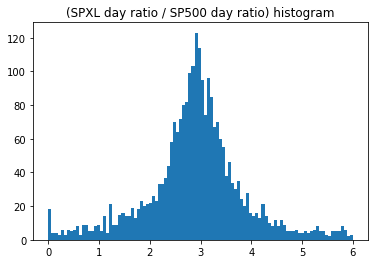

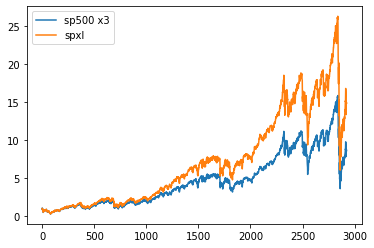

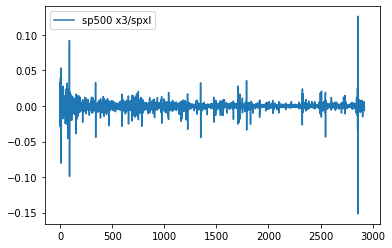

In [8]:
vs_spxl_sp500 = sp500_futures.loc[sp500_futures.Date.apply(lambda x: x  in spxl.Date.values )]
vs_spxl_sp500_plus1 = vs_spxl_sp500['day_ratio'].values+1
rr = spxl.day_ratio.values/(vs_spxl_sp500.day_ratio.values+ 1e-9)
plt.title('(SPXL day ratio / SP500 day ratio) histogram')
_ = plt.hist(rr, bins=100, range=(0,6))
plt.show()

n = 0
N = -1
sp500_ratio_3 = vs_spxl_sp500.day_ratio*3 + 1
cumprod_sp500_ratio_3 = np.cumprod(sp500_ratio_3.values)
t1 = (cumprod_sp500_ratio_3/cumprod_sp500_ratio_3[n])[n:N]
t2 = (spxl['Adj Close'].values/spxl['Adj Close'].iloc[n])[n:N]
plt.plot(t1, label='sp500 x3')
plt.plot(t2, label='spxl')
plt.legend()
plt.show()
plt.plot(np.diff(t1/t2), label='sp500 x3/spxl')
plt.legend()
plt.show()

#### 現物と比較

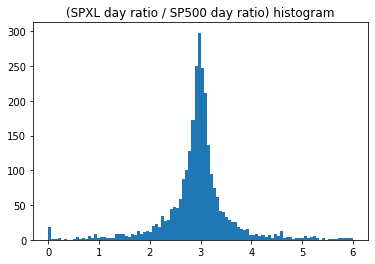

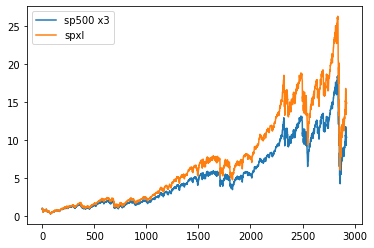

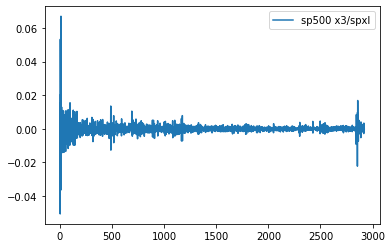

In [9]:
vs_spxl_sp500 = datas['sp500'].loc[datas['sp500'].Date.apply(lambda x: x  in spxl.Date.values )]
vs_spxl_sp500_plus1 = vs_spxl_sp500['day_ratio'].values+1
rr = spxl.day_ratio.values/(vs_spxl_sp500.day_ratio.values+ 1e-9)
plt.title('(SPXL day ratio / SP500 day ratio) histogram')
_ = plt.hist(rr, bins=100, range=(0,6))
plt.show()

n = 0
N = -1
sp500_ratio_3 = vs_spxl_sp500.day_ratio*3 + 1
cumprod_sp500_ratio_3 = np.cumprod(sp500_ratio_3.values)
t1 = (cumprod_sp500_ratio_3/cumprod_sp500_ratio_3[n])[n:N]
t2 = (spxl['Adj Close'].values/spxl['Adj Close'].iloc[n])[n:N]
plt.plot(t1, label='sp500 x3')
plt.plot(t2, label='spxl')
plt.legend()
plt.show()
plt.plot(np.diff(t1/t2), label='sp500 x3/spxl')
plt.legend()
plt.show()

乖離はあるがだいたい同じ挙動をしている. 何故か先物よりも現物の方がよく近似できた。
また一般に言う乖離は損な方向に働くものだとおもったけど買う側に有利な乖離だった

# もしリーマンショック以前にレバレッジETFがあったら

In [10]:
leverage = 3
for k in file_names:
    datas[k+'_x3'] = pd.DataFrame()
    ratio = datas[k].day_ratio*3
    #ratio.loc[ratio <= 0] = 1e-9
    datas[k+'_x3']['day_ratio'] = ratio 
    datas[k+'_x3']['Adj Close'] = np.cumprod(ratio+1)
    datas[k+'_x3']['Date'] = datas[k].Date

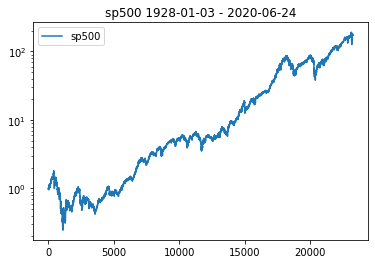

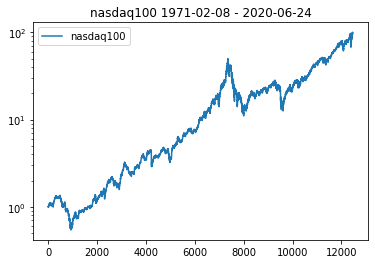

In [11]:
for k in file_names:
    x = datas[k].Date
    plt.title(f"{k} {x.iloc[0]} - {x.iloc[-1]}")
    l = k+'_x3'
    #plt.plot(datas[l]['Adj Close']/datas[l]['Adj Close'].iloc[0], label=l)
    l = k
    plt.plot(datas[l]['Adj Close']/datas[l]['Adj Close'].iloc[0], label=l)
    plt.yscale('log')
    plt.legend()
    plt.show()

In [12]:
results = {k:{} for k in datas.keys()}

# 買ったETF N年後どうなってる？

In [13]:
def exe1(values, day_num, iteration):
    res = []
    starts = np.random.choice(np.arange(len(values)-day_num), iteration) 
    for start in starts:
        res.append(values.iloc[start+day_num-1]/values.iloc[start])
    return res

In [14]:
default_years=[1,2,3,4,5,10,20,30]
index_names = ['sp500', 'sp500_x3', 'nasdaq100', 'nasdaq100_x3']

In [15]:
def make_data(exe, name, years=default_years, **kwargs):
    for k in tqdm(datas.keys(), total=len(datas.keys())):
        results[k][name] = {}
        for n in tqdm(years, leave=False):
            results[k][name][n] = exe(datas[k]['Adj Close'], day_num=n*240, **kwargs)

In [16]:
make_data(exe1, 'exe1', iteration=10000)

In [17]:
def show_hist(name, iteration=10000, years=default_years, bins=40, ranges=[[0,4], [0,40], [0,100]], ):
    for n in years:
        for k in index_names:
            if k[-1] != '3':
                for r in ranges:
                    #num, bins, patches = plt.hist([results[k][name][n], results[k+'_x3'][name][n]], bins=bins, ) # histogram
                    num1, _bins, _ = plt.hist(results[k][name][n], histtype='stepfilled', alpha=0.3, label=k+'_x1', range=r, bins=bins)
                    num2, _bins, _ = plt.hist(results[k+'_x3'][name][n], histtype='stepfilled', alpha=0.3, label=k+'_x3', range=r, bins=bins)
                    plt.grid()
                    plt.legend()
                    plt.xlabel('benfit x')
                    plt.ylabel('times')
                    plt.title(f'histgram {k} {n}years')
                    plt.show()
                    for i,_n in enumerate([num1, num2]):
                        plt.plot(_bins[:-1], np.cumsum(_n)/iteration*100, )
                    plt.legend([k+'_x1', k+'_x3'], loc='best')
                    plt.xlabel('benfit x')
                    plt.ylabel('%')
                    plt.grid()
                    plt.show()

In [26]:
def make_df(name, ):
    percentile = [1,5,10,15,20,25,50,75,80,85,90,95,99]
    res = []
    indexes = []
    for n in default_years:
        for k in index_names:
            indexes.append(f'{n}y_{k}')
            tmp = []
            for i in percentile:
                tmp.append(np.percentile(results[k][name][n], i)) 
            res.append(tmp)
    res = pd.DataFrame(res, index=indexes, columns=[f'{i}%' for i in percentile])
    return res

df1 = make_df('exe1')

In [32]:
df1.loc[df1.index.str.contains('0y_sp500')]

,1%,5%,10%,15%,20%,25%,50%,75%,80%,85%,90%,95%,99%
10y_sp500,0.489175,0.707662,0.955626,1.069697,1.183030,1.291254,1.890971,2.623420,2.741249,2.904713,3.140041,3.581514,4.088094
10y_sp500_x3,0.002883,0.062132,0.270978,0.463644,0.660244,0.881288,3.692196,8.588872,10.250500,12.970869,16.653858,26.091999,40.618665
20y_sp500,0.623169,1.433882,1.813820,1.960465,2.138349,2.331907,3.433832,5.416257,5.733288,6.043438,6.778178,9.703927,11.509108
20y_sp500_x3,0.002179,0.050597,1.294472,1.939398,2.431687,2.818405,8.341775,44.339483,61.311876,77.279710,111.743461,211.523215,318.344446
30y_sp500,1.669088,3.424344,4.321695,4.763024,5.100622,5.332809,7.095433,9.384714,10.038202,11.236849,12.266943,13.826493,15.360784
30y_sp500_x3,0.025847,0.513359,13.356891,16.949463,20.530621,23.148324,42.777758,108.959319,144.188946,186.234994,231.822031,305.813187,479.692686


In [20]:
def show_hakohige(name, years=default_years, ):
    for kk in file_names:
        for k in [kk, kk+'_x3']: 
            labels = []
            # 箱ひげ図
            fig, ax = plt.subplots()
            plt.title(f'{k}')
            # ラベル名
            plt.xlabel('year')
            plt.ylabel('benefit x')
            # Y軸のメモリの長さ
            plt.grid()
            points = []
            for n in years:
                labels.append(n)
                points.append(results[k][name][n])
            plt.yscale('log')
            ax.boxplot(points, showfliers=False)
            ax.set_xticklabels(labels)
            plt.show()

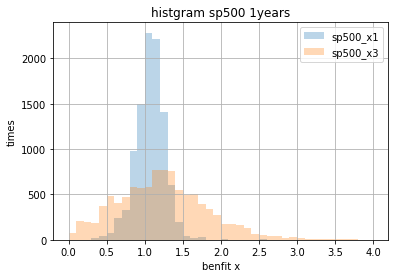

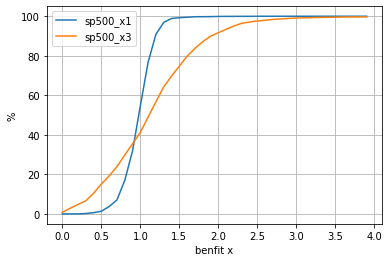

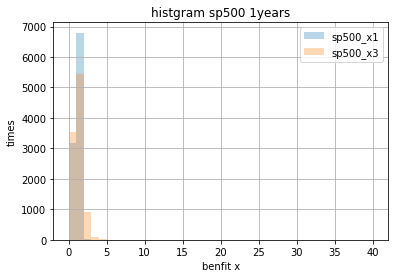

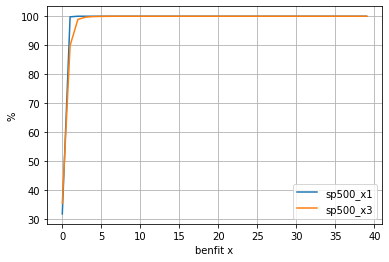

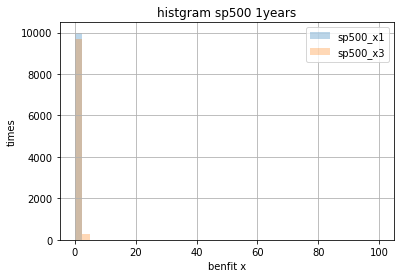

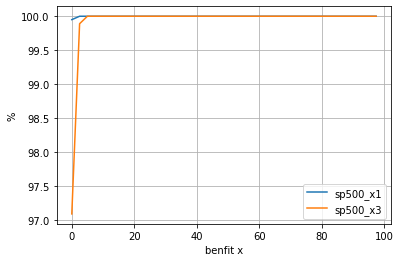

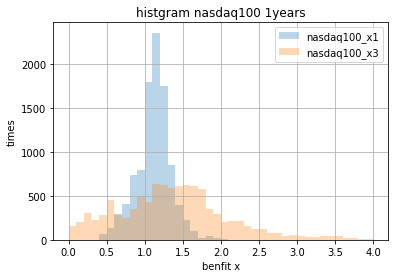

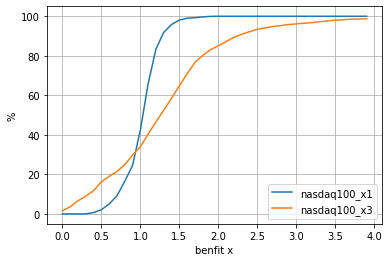

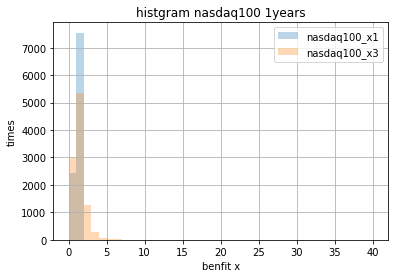

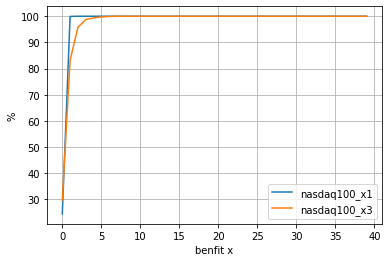

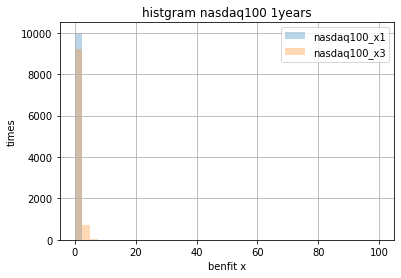

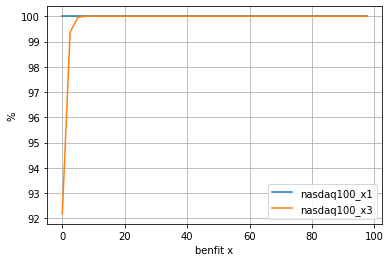

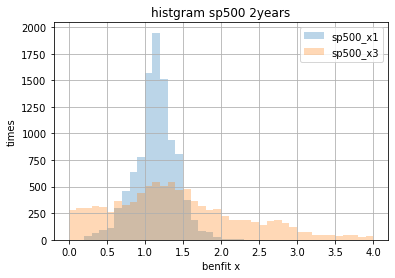

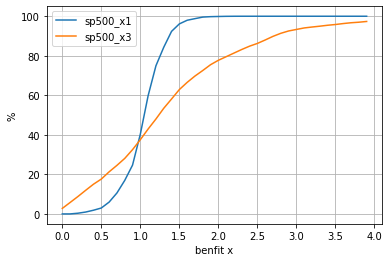

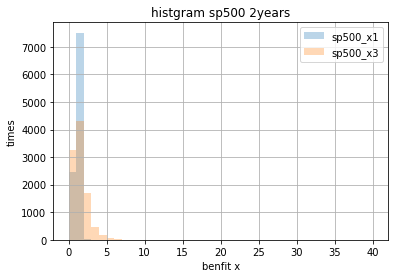

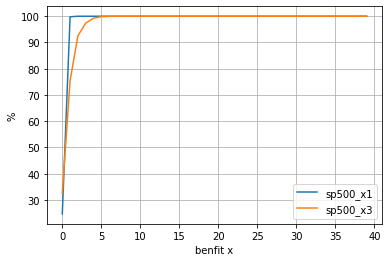

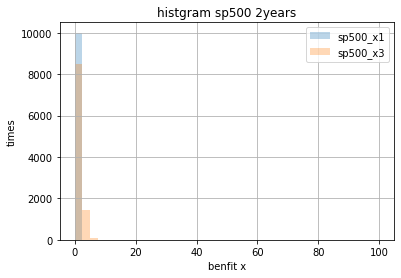

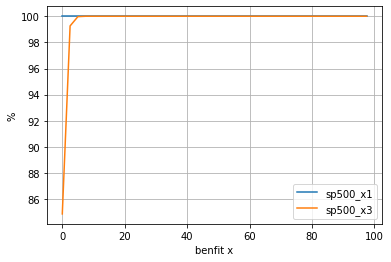

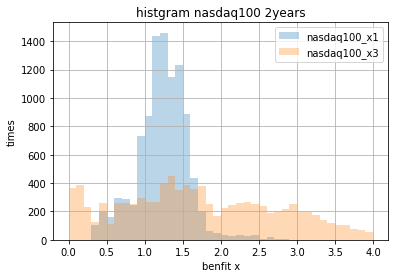

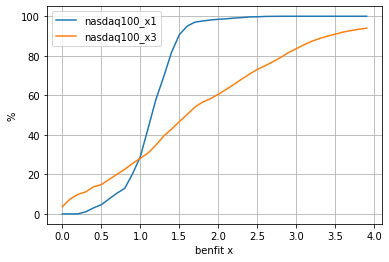

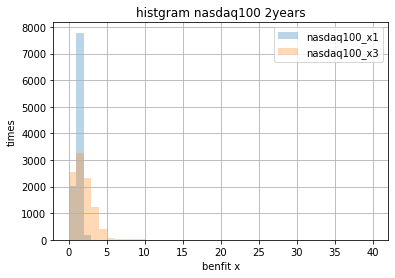

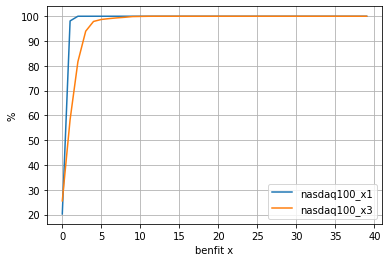

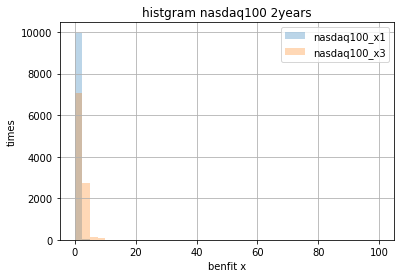

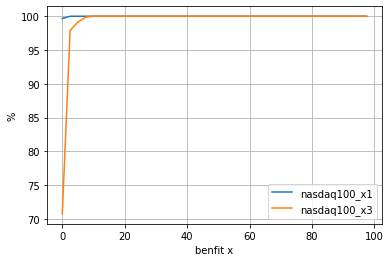

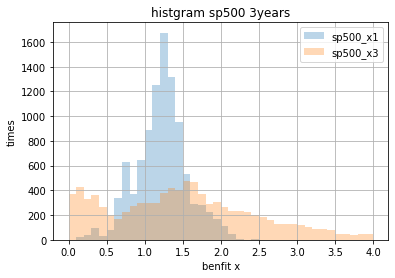

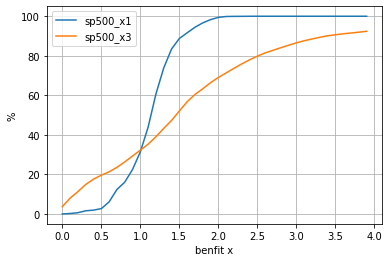

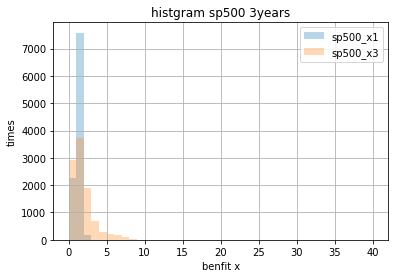

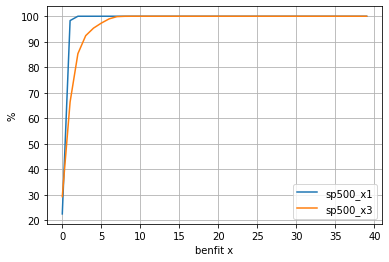

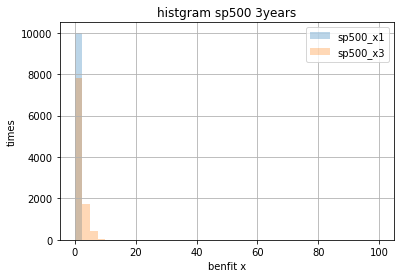

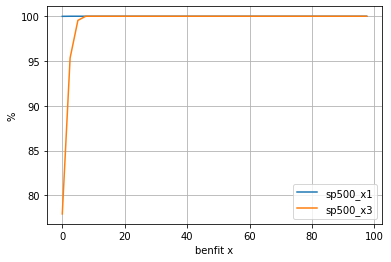

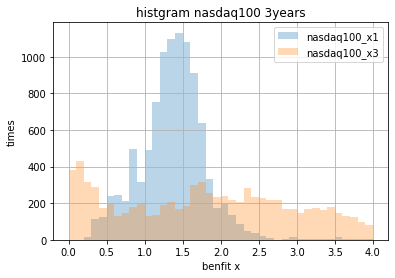

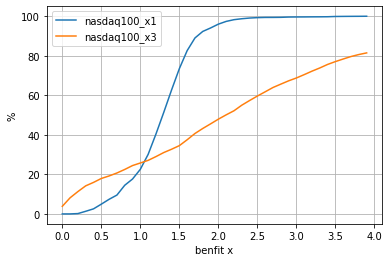

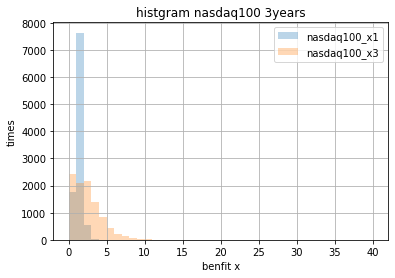

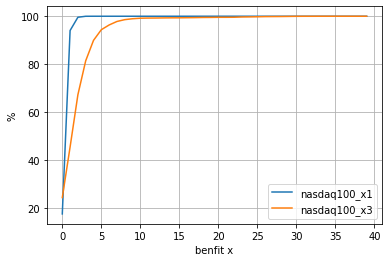

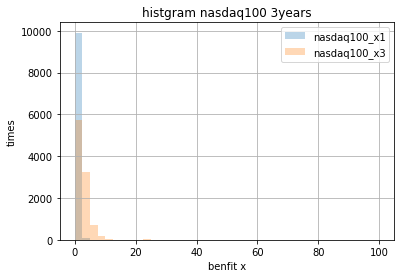

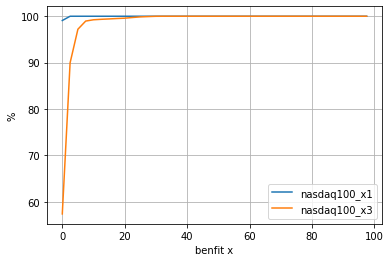

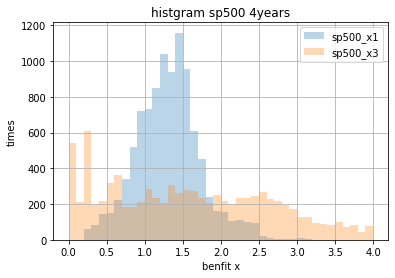

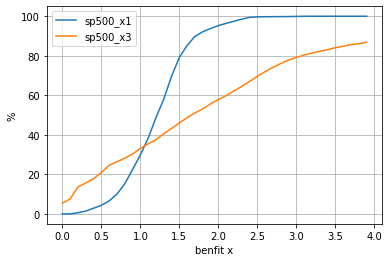

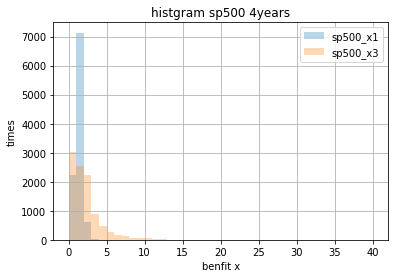

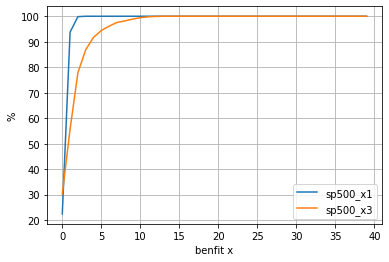

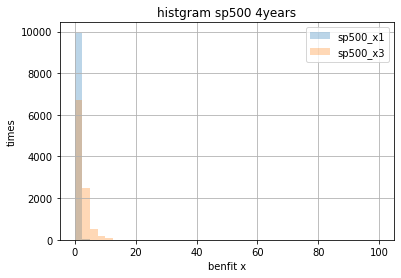

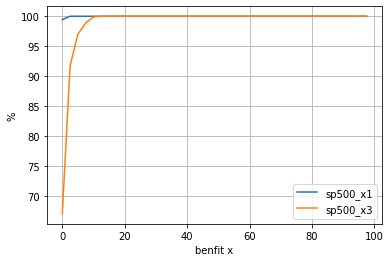

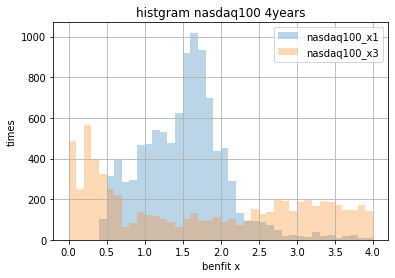

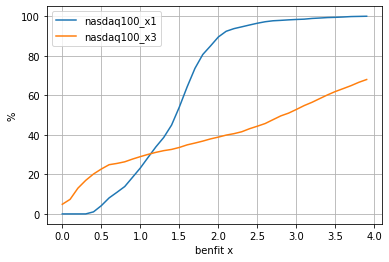

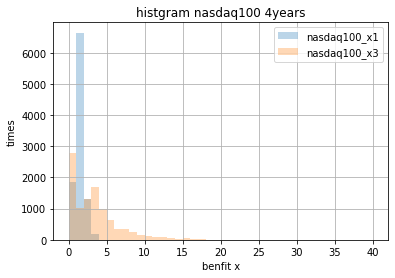

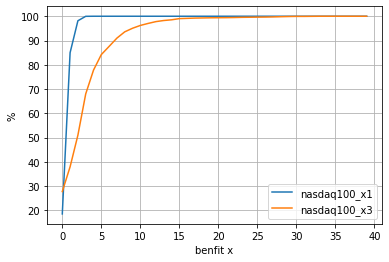

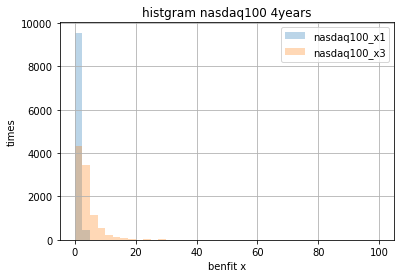

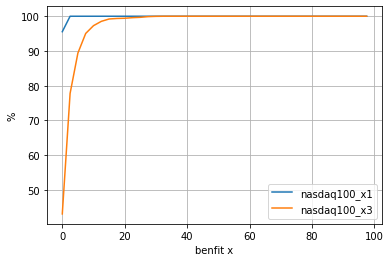

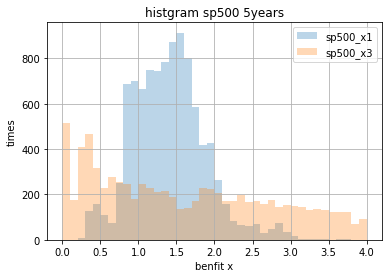

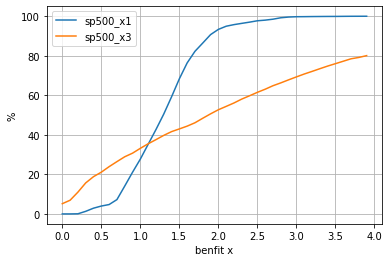

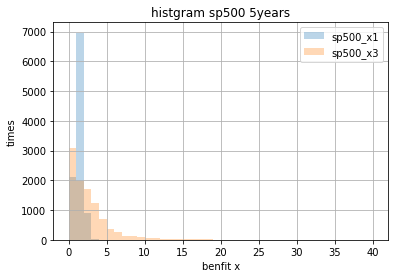

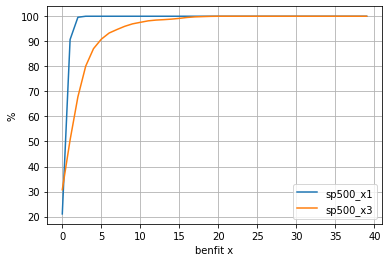

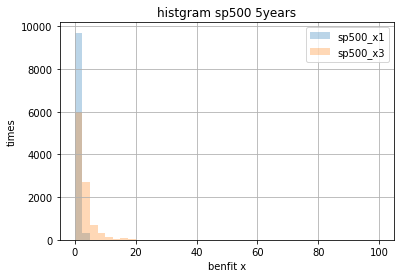

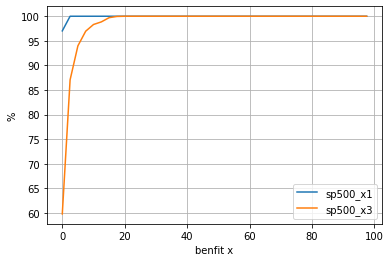

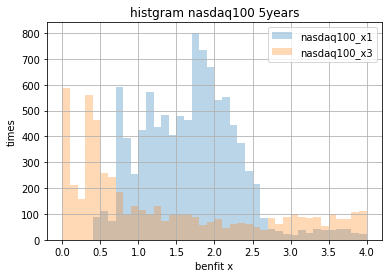

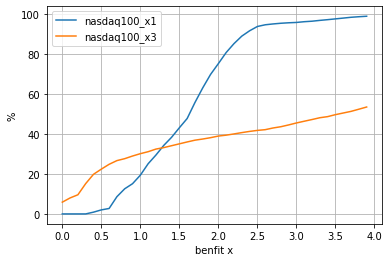

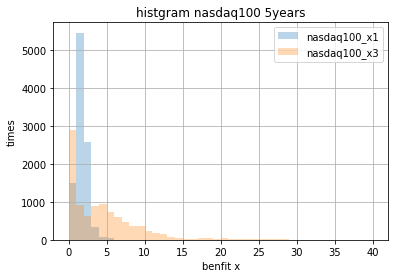

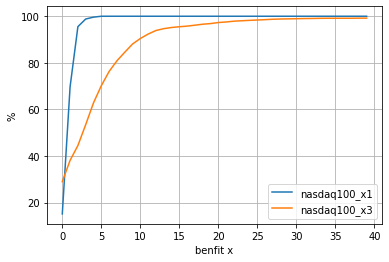

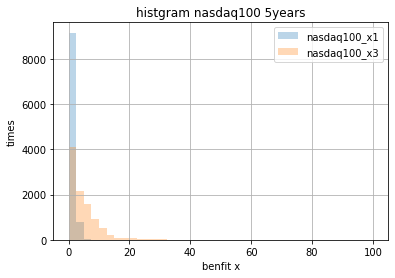

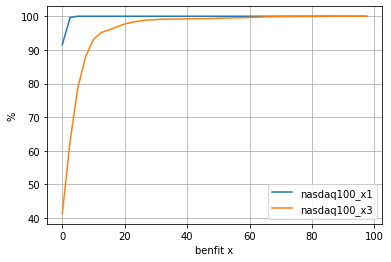

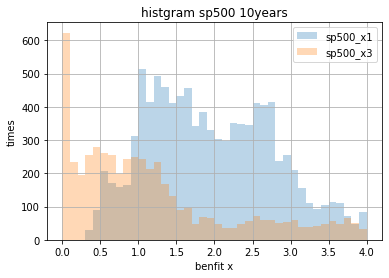

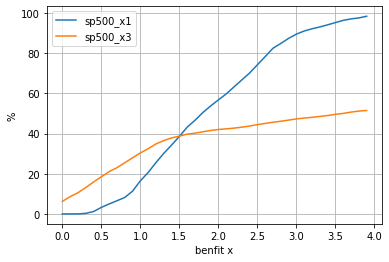

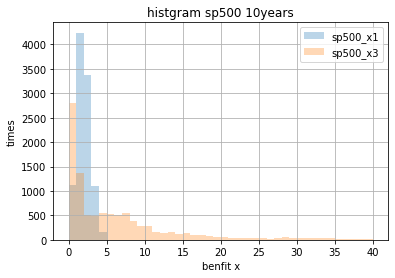

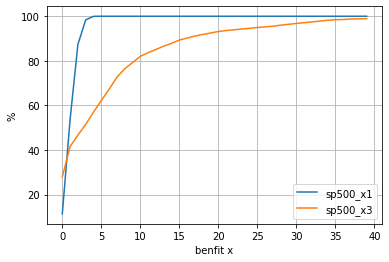

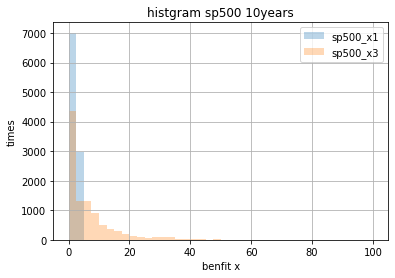

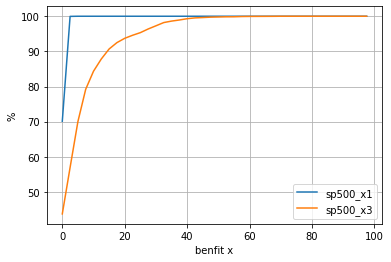

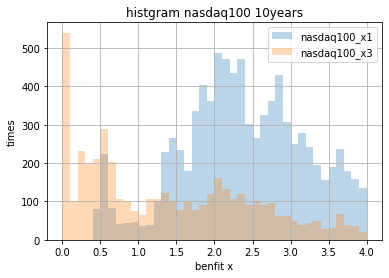

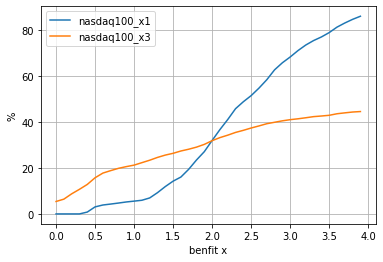

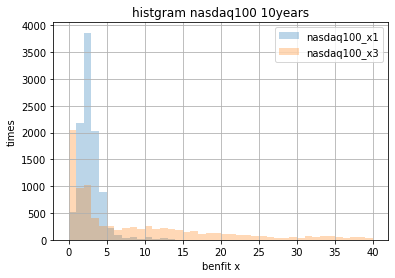

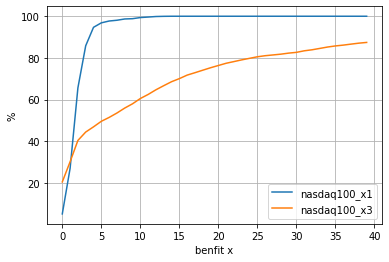

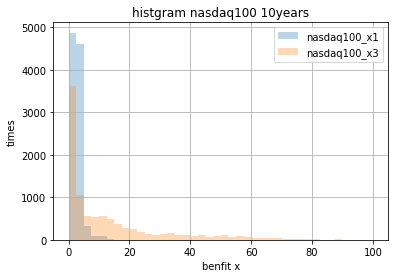

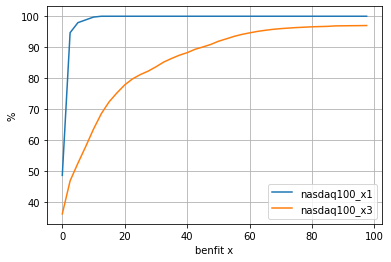

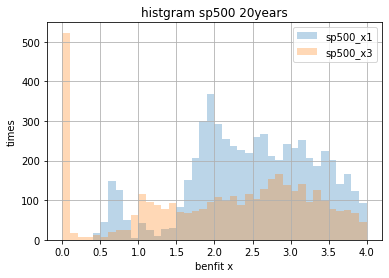

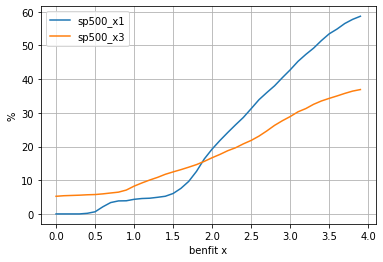

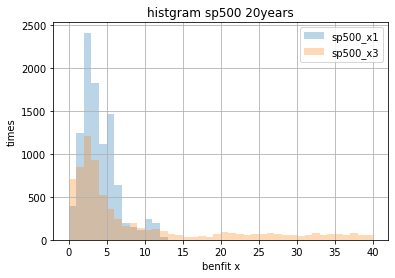

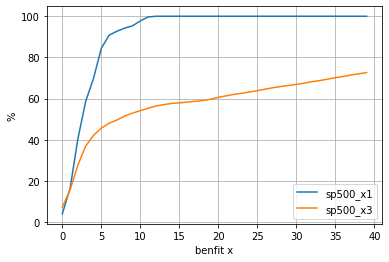

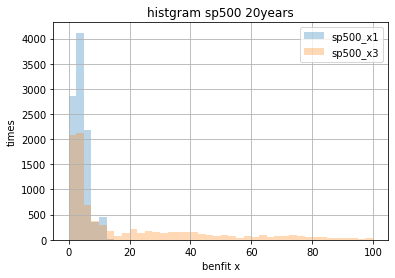

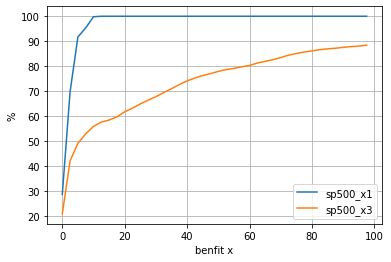

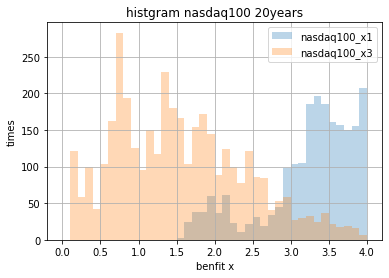

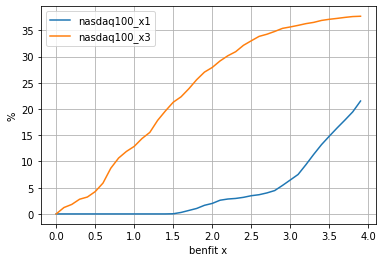

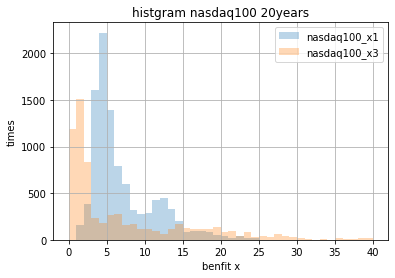

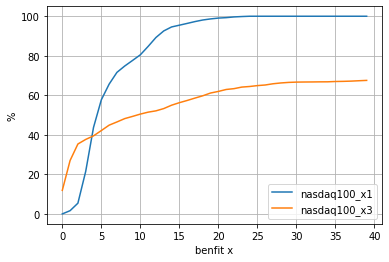

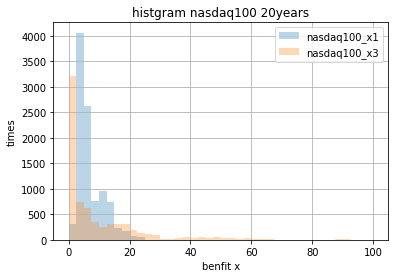

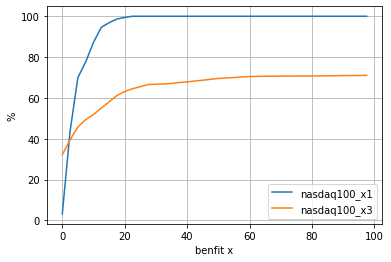

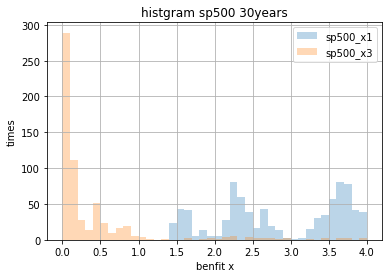

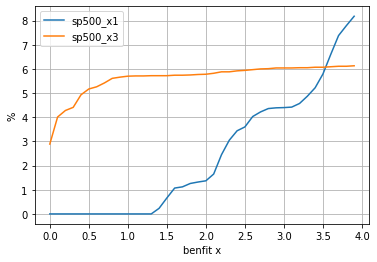

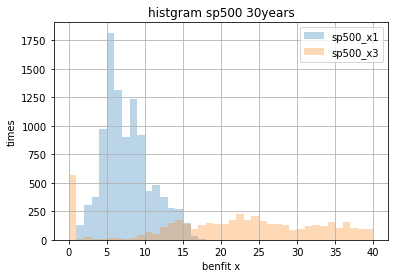

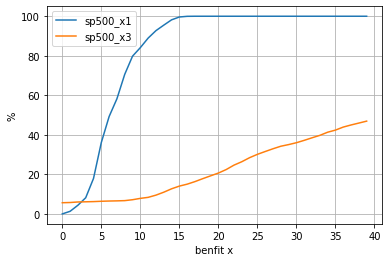

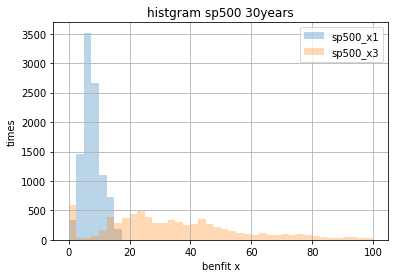

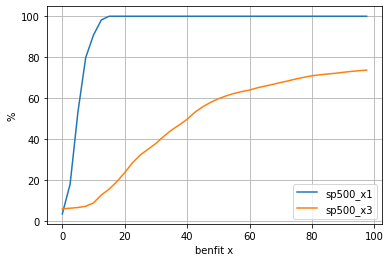

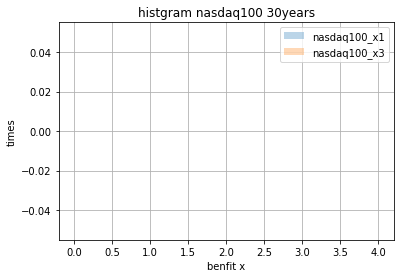

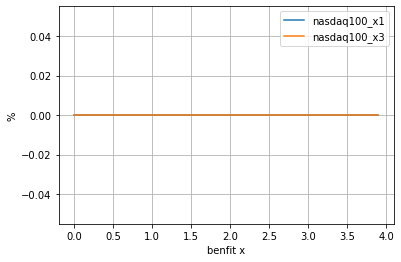

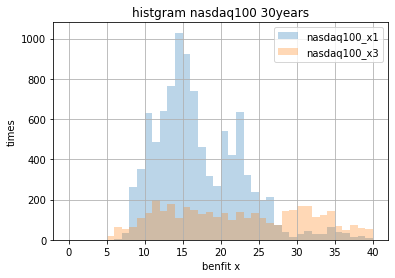

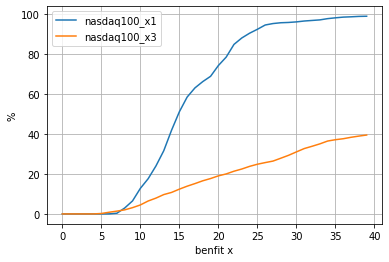

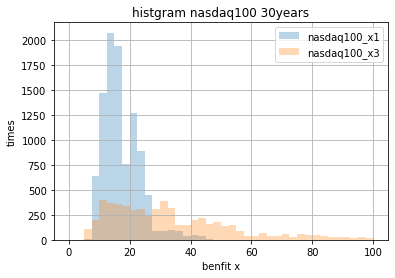

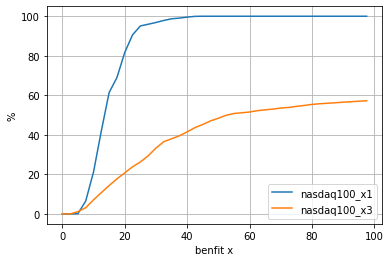

In [21]:
show_hist('exe1')

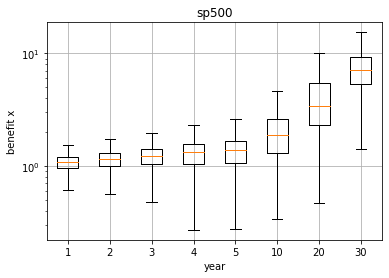

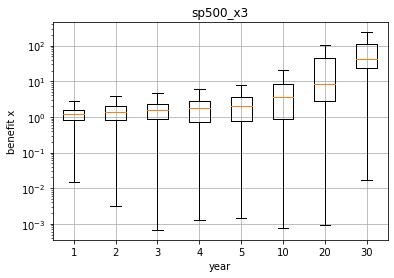

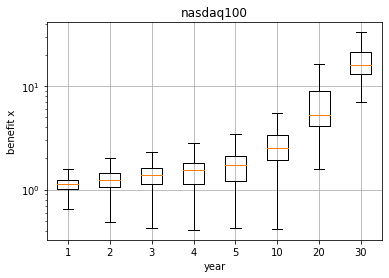

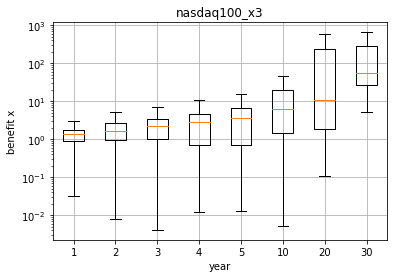

In [22]:
show_hakohige('exe1')

# N年間積立投資をした場合

In [ ]:
def exe2(values, day_num, iteration):
    res = []
    starts = np.random.choice(np.arange(len(values)-day_num), iteration) 
    for start in starts:
        res.append(values[start+day_num-1]*np.mean(1/values[start:start+day_num].values))
    return res

In [ ]:
make_data(exe2, 'exe2', iteration=10000)

In [ ]:
show_hist('exe2')

In [ ]:
show_hakohige('exe2')

In [ ]:
df2 = make_df('exe2')
df2

In [ ]:
df2.iloc[3:-1:4].T.plot()
plt.yscale('log')
plt.grid()

# Ny-200d定期買い、200d定期売り

In [ ]:
def exe3(values, day_num, iteration):
    res = []
    starts = np.random.choice(np.arange(len(values)-day_num), iteration) 
    for start in starts:
        mid = start+day_num-200
        end = start+day_num
        num = np.sum(1/values[start:mid].values)/(end-mid)
        res.append(num*np.sum(values[mid:end])/(mid-start))
    return res

In [ ]:
make_data(exe3, 'exe3', iteration=10000)

In [ ]:
show_hakohige('exe3')

In [ ]:
show_hist('exe3')

In [ ]:
df3 = make_df('exe3')
df3.loc[df3.index.str.contains('_10')]

In [ ]:
df2 = make_df('exe2')
df2.loc[df2.index.str.contains('_10')]

In [ ]:
df1.loc[df1.index.str.contains('_10')]

# 死亡(10%以下)、危篤(10-50)、重症(50-80)、軽症(80-90)、小康（90-100）、ハッピー(100-200）、ウルトラハッピー（200-1000）、テンバガー（1000-）

In [ ]:
score_dict = {'<=0.1': lambda x: x<0.1, '<=0.5': lambda x: 0.1<=x<0.5, '<=0.8': lambda x: 0.5<x<=0.8, '<=0.9': lambda x:0.8<x<=0.9,
             '  <=1': lambda x: 0.9<x<=1, '  <=2': lambda x:1<x<=2, '  <=5': lambda x: 2<x<=5, ' <=10': lambda x: 5<x<=10, '  >10':lambda x:10<x}

res = {}
for f in index_names:
    res[f] = {}
    for e in ['exe1', 'exe2']:
        res[f][e] = {}
        for n in default_years:
            res[f][e][n] = {k: 0 for k in score_dict.keys()}
            for s in results[f][e][n]:
                for k in score_dict.keys():
                    if score_dict[k](s):
                        res[f][e][n][k] += 1
                        break
            

In [ ]:
for f in index_names:
    for e in ['exe1', 'exe2']:
        print('name\t\t\t '+' '.join([k for k in score_dict.keys()]))
        for n in default_years:
            print(f'{f} {e} {n:02d}\t'+('\t' if f=='sp500' else '') +''.join([' {0:5d}'.format(res[f][e][n][k]) for k in score_dict.keys()]))